In [8]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import nltk
from soynlp.normalizer import *
from hanspell import spell_checker
from konlpy.tag import Okt

# ML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

# 한글화
from matplotlib import font_manager, rc
path = 'C:/Windows/Fonts/malgun.ttf'
rc('font', family='Malgun Gothic')


---

### 전처리 (라벨링 -> 한글로만 정제 -> 맞춤법 검사 -> 토큰화 -> 불용어처리 -> 컬럼정리 및 파일저장)

In [9]:
# 파일 불러오기 및 불필요 컬럼 정리
df = pd.read_csv('./df_review.csv', encoding='utf-8') # df_review는 전체년도 리뷰 크롤링 파일
df = df[pd.to_datetime(df['at']).dt.year == 2022]

review_df = df[['at', 'userName', 'score', 'content']]
review_df.columns = ['날짜', '닉네임', '평점', '전처리 전 리뷰']

review_df = review_df.reset_index(drop=True)
review_df.head()

,날짜,닉네임,평점,전처리 전 리뷰
0,2022-12-31 09:59:29,이슬아,1,반품 여러개 한번에 했는데 제때 처리안되는거보니 물류시스템이 별로인걸로 추정. 부분...
1,2022-12-31 06:35:40,민덕,5,마켓 컬리 ! 한마디만 하겟슴 킹왕짱
2,2022-12-30 22:36:44,김민,5,마켓컬리 좋아용 편하고 배송 왕 빠름 !! 물건이 조금 더 다양했으면 좋겠어요
3,2022-12-30 18:06:57,백진옥,5,오래 동안 사용을 했구요 너무 좋읍니다 제가 근성 피부라 마데카 이외는 다른 화장 ...
4,2022-12-30 17:40:33,박민정,1,일시적장애는 왜자꾸나오죠? 업데이트했는데도그러네요.. 주문을할수가없네..


In [10]:
# 영어, 숫자, 특수문자, 이모티콘 제거 (soynlp normalize로 한 번에 해결)
review_df['한글화된 리뷰'] = review_df['전처리 전 리뷰'].apply(lambda x: normalize(x))
review_df[['전처리 전 리뷰', '한글화된 리뷰']].sample(10)

,전처리 전 리뷰,한글화된 리뷰
2589,사용하기 편해요,사용하기 편해요
2254,최고,최고
2162,제품도 신선하고 혜택도 좋아요 항상 만족합니다,제품도 신선하고 혜택도 좋아요 항상 만족합니다
1172,쿠폰좀 많이주세요ㅠㅠ,쿠폰좀 많이주세요ㅠㅠ
1758,종종 이용합니다. 새벽배송 좋아요,종종 이용합니다 새벽배송 좋아요
2210,앱 잘 쓰고 있는데 찜목록 200개가 저는 부족해서 더 늘려주셨으면 좋겠어요 편하려...,앱 잘 쓰고 있는데 찜목록 개가 저는 부족해서 더 늘려주셨으면 좋겠어요 편하려고 쓰...
1805,너무 소용량밖에 없다,너무 소용량밖에 없다
2194,상품도 좋고 다 마음에 드는데 스티로폼 박스가 항상 깨져서 와요 배송중에 그렇게 되...,상품도 좋고 다 마음에 드는데 스티로폼 박스가 항상 깨져서 와요 배송중에 그렇게 되...
1243,최악입니다 다른거 쓰세요 배송지 입력 오류 1시간째 지속되고 오류 안나는게 없네,최악입니다 다른거 쓰세요 배송지 입력 오류 시간째 지속되고 오류 안나는게 없네
466,덕분에 새벽배송으로 편하게 맛있는 음식을 먹고 있어서 감사합니다. 그런데 결제시에 ...,덕분에 새벽배송으로 편하게 맛있는 음식을 먹고 있어서 감사합니다 그런데 결제시에 네...


In [11]:
# 맞춤법 검사 (3분 내외 소요('22년도 1년치 기준))
errors = []

def spell_check(text):
    try:
        result = spell_checker.check(text)
        return result.checked
    except:
        errors.append(review_df[review_df['한글화된 리뷰'] == text].index[0])
        return text  

review_df['맞춤법 정리된 리뷰'] = review_df['한글화된 리뷰'].apply(spell_check)

# # 에러 발생 시 살펴보기
# for idx in errors:
#     print(f"Error at index {idx}: {review_df.loc[idx, '한글화된 리뷰']}")

In [12]:
review_df[['한글화된 리뷰', '맞춤법 정리된 리뷰']].sample(10)

,한글화된 리뷰,맞춤법 정리된 리뷰
482,이것도 앱이라고 업뎃후 주문이 안되네요 자사 망하라는 앱인가여,이것도 앱이라고 업데이트 후 주문이 안되네요 자사 망하라는 앱인가요
1317,빨리 와서줗아요,빨리 와서줗아요
2270,진작쓸걸,진작 쓸걸
2404,제품이며 배송이며 모두 좋아요,제품이며 배송이며 모두 좋아요
656,첫구매다 머다 어그로 끌면서 물량 없거나 첫구매 이벤트 페이지 찾기도 힘들고 이런식...,첫 구매다 먹다 어 그로 끌면서 물량 없거나 첫 구매 이벤트 페이지 찾기도 힘들고 ...
3039,편하고 좋아요 혼자살면 조금씩 시켜야하는데 너무 찰떡,편하고 좋아요 혼자 살면 조금씩 시켜야 하는데 너무 찰떡
829,업데이트하고 나서 왜 자꾸 로그아웃되는 건가요 로그인유지 버튼이라도 만들어두던가요 ...,업데이트하고 나서 왜 자꾸 로그아웃되는 건가요 로그인 유지 버튼이라도 만들어두던가요...
2886,맛좋은 상품이 보기쉽게 되있어서 좋네요,맛 좋은 상품이 보기 쉽게 돼있어서 좋네요
1068,소량과 다양함에 만족합니다,소량과 다양함에 만족합니다
2120,쿠팡에서 넘어왔어요 마켓컬리화이팅,쿠팡에서 넘어왔어요 마켓 컬리 파이팅


In [13]:
# 토큰화
t = Okt()

def tokenize_text(text):
    tokens = t.morphs(text)
    return tokens

review_df['토큰화된 리뷰'] = review_df['맞춤법 정리된 리뷰'].apply(tokenize_text)

review_df[['맞춤법 정리된 리뷰', '토큰화된 리뷰']].sample(10)

,맞춤법 정리된 리뷰,토큰화된 리뷰
3125,장 보기 편해요 굿,"[장, 보기, 편해요, 굿]"
36,사용하기 간편해 옹,"[사용, 하기, 간편해, 옹]"
1373,좋네요,[좋네요]
707,첨 가입하고 쓰려는데 로그인하면 컬리 추천 신상품 베스트 탭이 전혀 보이지 않습니다...,"[첨, 가입, 하고, 쓰려는데, 로그인, 하면, 컬리, 추천, 신, 상품, 베스트,..."
3308,좋아요 감사합니다,"[좋아요, 감사합니다]"
81,다양한 분야를 한곳에서 찾아보고 구매 가능해서 좋았고 특정지역의 유명 업소 제품을 ...,"[다양한, 분야, 를, 한, 곳, 에서, 찾아보고, 구매, 가능해서, 좋았고, 특정..."
1601,수은 그림 찾기,"[수은, 그림, 찾기]"
2818,좋아요,[좋아요]
183,좋아요,[좋아요]
1693,제품 배송 포장 모두 만족합니다,"[제품, 배송, 포장, 모두, 만족합니다]"


In [16]:
# 불용어 제거 : RankNL 
with open('RankNL.txt', 'r', encoding='utf-8') as f:
    stopwords = f.readlines()
    stopwords = [word.strip() for word in stopwords]
print('RankNL 불용어 개수 : ' + str(len(stopwords)))

# 불용어 제거 : 수작업
stopwords_to_add = ['이', '에', '도', '가', '을', '안', '하고', '것', '들', '를', '로', '수', '할', '으로', '거', '은', '한', '다', '만', '는', '적', '후', '하기', '요', '해', '에서', '있어요', '입니다', '여러', '개', '번', '되는', '보니', '하겟슴', '했고요', '제', '라', '마', '해요', '지', '있음', '과', '의', '인데', '하기에']
stopwords.extend(stopwords_to_add)
print('수작업 불용어 개수 : ' + str(len(stopwords_to_add)))
print('총 불용어 개수 : ' + str(len(stopwords)))

RankNL 불용어 개수 : 675
수작업 불용어 개수 : 45
총 불용어 개수 : 720


In [17]:
def remove_stopwords(tokens):
    words = [word for word in tokens if word not in stopwords]
    return words

review_df['불용어 제거된 리뷰'] = review_df['토큰화된 리뷰'].apply(remove_stopwords)

review_df[['토큰화된 리뷰', '불용어 제거된 리뷰']].sample(10)

,토큰화된 리뷰,불용어 제거된 리뷰
2846,"[가격, 이, 조금, 저렴하면, 더, 좋겠지만, 앱, 사용, 에는, 만족합니다]","[가격, 저렴하면, 더, 좋겠지만, 앱, 사용, 에는, 만족합니다]"
1216,"[혹시, 장바구니, 에서, 한꺼, 번, 에, 선물, 하기, 가능하게, 개선, 가능할...","[장바구니, 한꺼, 선물, 가능하게, 개선, 가능할까, 굳이, 새벽, 배송, 필요,..."
1970,[좋아요],[좋아요]
2307,"[앱, 이, 훨씬, 쓰기, 편하네요]","[앱, 쓰기, 편하네요]"
930,"[어제, 부터, 자꾸, 업데이트, 하, 라고, 하고, 짜증, 나네요, 로그인, 도,...","[어제, 자꾸, 업데이트, 라고, 짜증, 나네요, 로그인, 계속, 해야, 장바구니,..."
1525,"[너무, 좋아요, 쇼핑, 하기, 편하게, 잘, 되어있고, 한눈, 에, 쏙, 들어와요]","[너무, 좋아요, 쇼핑, 편하게, 잘, 되어있고, 한눈, 쏙, 들어와요]"
670,"[업데이트, 후, 장바구니, 에, 담기질, 않네요]","[업데이트, 장바구니, 담기질, 않네요]"
1199,"[비만, 자, 들]",[비만]
1359,[좋음],[좋음]
3104,"[판, 에서, 갈아탔습니다, 값, 도, 팡, 대비, 저렴하고, 계란, 빼고, 상품,...","[판, 갈아탔습니다, 값, 팡, 대비, 저렴하고, 계란, 빼고, 상품, 찾기, 편하..."


In [18]:
# 라벨링
def label_sentiment(score):
    if score <= 3:
        return 0
    else:
        return 1

review_df['라벨'] = review_df['평점'].apply(label_sentiment)
review_df.head()

,날짜,닉네임,평점,전처리 전 리뷰,한글화된 리뷰,맞춤법 정리된 리뷰,토큰화된 리뷰,불용어 제거된 리뷰,라벨
0,2022-12-31 09:59:29,이슬아,1,반품 여러개 한번에 했는데 제때 처리안되는거보니 물류시스템이 별로인걸로 추정. 부분...,반품 여러개 한번에 했는데 제때 처리안되는거보니 물류시스템이 별로인걸로 추정 부분환...,반품 여러 개 한 번에 했는데 제때 처리 안 되는 거 보니 물류 시스템이 별로인 걸...,"[반품, 여러, 개, 한, 번, 에, 했는데, 제때, 처리, 안, 되는, 거, 보니...","[반품, 했는데, 제때, 처리, 물류, 시스템, 별로, 인, 걸, 추정, 부분, 환...",0
1,2022-12-31 06:35:40,민덕,5,마켓 컬리 ! 한마디만 하겟슴 킹왕짱,마켓 컬리 한마디만 하겟슴 킹왕짱,마켓 컬리 한마디만 하겟슴 킹왕짱,"[마켓, 컬리, 한마디, 만, 하겟슴, 킹왕짱]","[마켓, 컬리, 킹왕짱]",1
2,2022-12-30 22:36:44,김민,5,마켓컬리 좋아용 편하고 배송 왕 빠름 !! 물건이 조금 더 다양했으면 좋겠어요,마켓컬리 좋아용 편하고 배송 왕 빠름 물건이 조금 더 다양했으면 좋겠어요,마켓 컬리 좋아요 편하고 배송 왕 빠름 물건이 조금 더 다양했으면 좋겠어요,"[마켓, 컬리, 좋아요, 편하고, 배송, 왕, 빠름, 물건, 이, 조금, 더, 다양...","[마켓, 컬리, 좋아요, 편하고, 배송, 왕, 빠름, 물건, 더, 다양했으면, 좋겠어요]",1
3,2022-12-30 18:06:57,백진옥,5,오래 동안 사용을 했구요 너무 좋읍니다 제가 근성 피부라 마데카 이외는 다른 화장 ...,오래 동안 사용을 했구요 너무 좋읍니다 제가 근성 피부라 마데카 이외는 다른 화장 ...,오랫동안 사용을 했고요 너무 좋습니다 제가 근성 피부라 마데카 이외는 다른 화장 품...,"[오랫동안, 사용, 을, 했고요, 너무, 좋습니다, 제, 가, 근성, 피부, 라, ...","[오랫동안, 사용, 너무, 좋습니다, 근성, 피부, 데카, 이외, 화장, 품, 사용...",1
4,2022-12-30 17:40:33,박민정,1,일시적장애는 왜자꾸나오죠? 업데이트했는데도그러네요.. 주문을할수가없네..,일시적장애는 왜자꾸나오죠 업데이트했는데도그러네요 주문을할수가없네,일시적 장애는 왜 자꾸 나오죠 업데이트했는데도 그러네요 주문을 할 수가 없네,"[일시, 적, 장애, 는, 왜, 자꾸, 나오죠, 업데이트, 했는데도, 그러네요, 주...","[일시, 장애, 자꾸, 나오죠, 업데이트, 했는데도, 그러네요, 주문, 수가, 없네]",0


In [19]:
# # 컬럼정리 및 파일저장
neworder = ['날짜', '닉네임', '평점', '라벨', '불용어 제거된 리뷰']
review_df = review_df[neworder]
review_df.rename(columns={'불용어 제거된 리뷰' : '리뷰'}, inplace=True)

review_df.to_csv('review_preprocessed.csv', index=False)

---

### 전처리된 데이터 확인

In [20]:
review = pd.read_csv('review_preprocessed.csv', encoding='utf-8')
review.head()

,날짜,닉네임,평점,라벨,리뷰
0,2022-12-31 09:59:29,이슬아,1,0,"['반품', '했는데', '제때', '처리', '물류', '시스템', '별로', '..."
1,2022-12-31 06:35:40,민덕,5,1,"['마켓', '컬리', '킹왕짱']"
2,2022-12-30 22:36:44,김민,5,1,"['마켓', '컬리', '좋아요', '편하고', '배송', '왕', '빠름', '물..."
3,2022-12-30 18:06:57,백진옥,5,1,"['오랫동안', '사용', '너무', '좋습니다', '근성', '피부', '데카',..."
4,2022-12-30 17:40:33,박민정,1,0,"['일시', '장애', '자꾸', '나오죠', '업데이트', '했는데도', '그러네..."


In [21]:
token_lists = review['리뷰'].apply(eval).tolist()
all_tokens = [token for sublist in token_lists for token in sublist]
checking = nltk.Text(all_tokens, name = '토큰 모음')

print(len(checking))
print(len(set(checking)))
print(checking.count('배송'))


31259
5528
651


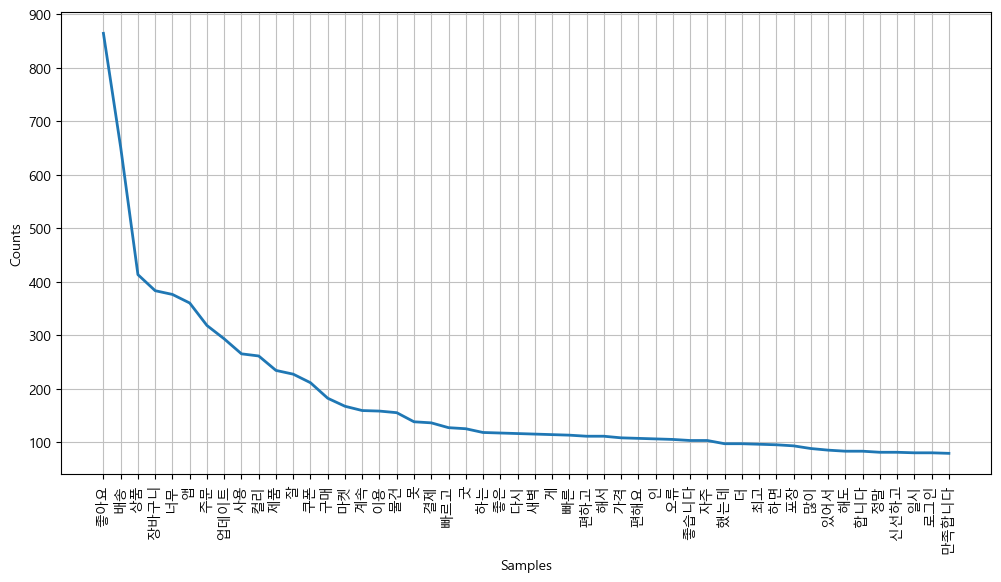

In [22]:
plt.figure(figsize=(12,6))
checking.plot(50)
plt.show()

---

### Vectorizing(tfidf, count) 및 Logistic Regression

In [23]:
tfidf = TfidfVectorizer(min_df=10, decode_error='ignore') # max_features=3000

contents_for_vectorize = [' '.join(eval(content)) for content in review['리뷰']]
# or 뒤에 X = tfidf.fit_transform(review['리뷰'].astype(str)).toarray()

X = tfidf.fit_transform(contents_for_vectorize)
y = review['라벨']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

lr = LogisticRegression(solver='liblinear', random_state=13)
lr.fit(X_train, y_train)

y_pred_tr = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

print('Train Acc : ', accuracy_score(y_train, y_pred_tr))
print('Test Acc : ', accuracy_score(y_test, y_pred_test))

Train Acc :  0.9341427520235467
Test Acc :  0.9294117647058824


In [24]:
count = CountVectorizer(max_features=4000) # min_df=1, decode_error='ignore'

contents_for_vectorize = [' '.join(eval(content)) for content in review['리뷰']]
# or 뒤에 X = tfidf.fit_transform(review['리뷰'].astype(str)).toarray()

X = count.fit_transform(contents_for_vectorize)
y = review['라벨']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

lr = LogisticRegression(solver='liblinear', random_state=13)
lr.fit(X_train, y_train)

y_pred_tr = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

print('Train Acc : ', accuracy_score(y_train, y_pred_tr))
print('Test Acc : ', accuracy_score(y_test, y_pred_test))

Train Acc :  0.9701986754966887
Test Acc :  0.9264705882352942
